## Whole Slide Imaging De-identification V2

**🟡 Version 1** </br>

In this notebook, we will explore how to handle the de-identification of Whole Slide Imaging (WSI) files, specifically focusing on SVS files.</br>
We will cover:
* Removal of auxiliary images, like macro and label images.
* Removal of Metadata.
* Main image cleaning: in this situation we don't want to remove the entire image like the case of for example macro or label images, but we want to remove only specific regions which contain PHI. We want to do this keeping the quality of the original image intact. This process involves the following steps which we will discuss in next sections,
  * Extract Tiles from SVS
  * Deidentify Tiles
  * Update the original source SVS file to mask tiles containing PHI.

Let's jump right in!

**✅ Improvements in Version 2** </br>

This version introduces several enhancements for efficiency and completeness:

**Thumbnail Support**:
  * Extract Thumbnail from SVS
  * Deidentify Thumbnail

**Tile Deidentification Optimization**:

  * Process only one selected level
  * Scale deidentified regions across other levels automatically

**Performance Enhancements**:

  * Dynamic multiprocessing and batching based on system resources

**Pretrained Deidentification Pipeline Integration**:

  * All stages are embedded within a single model, making the de-identification process much clearer and simpler


### Introduction to the SVS file format

The SVS file format (commonly used for whole slide images (WSI) in digital pathology) is based on the TIFF format and supports multi-resolution (pyramidal) image storage. It allows storing extremely large images efficiently, along with metadata and multiple resolutions for fast zooming and viewing.
SVS typically stores images in a pyramid of resolutions,
* level 0 -> full resolution.
* level 1 -> downsampled version, like 1/4 of the resolution at level 0.
* ...
* level N -> more downsampling.

Something like this(image taken from nema.org),</br>
![sample wsi](https://dicom.nema.org/dicom/dicomwsi/sup145_fromword_files/image008.gif)

At each level, images are not stored as a single monolithic unit, but as a set of _tiles_. This enables for a more efficient handling of the image by viewers.</br>
We'll see how we can exploit this characteristic to process the images in parallel and in the most efficient manner.

### Real World Example

In [ ]:
secret = ""
license = ""
aws_access_key = ""
aws_secret_key = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.12"

### Initialization of spark session

In [ ]:
from sparkocr import start
import os
import sys

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key

nlp_secret = ""

spark = start(secret=secret,
              jar_path=spark_ocr_jar_path, nlp_internal="6.1.0", nlp_version="6.1.1", nlp_secret=nlp_secret)

spark

### Removal of auxiliary images, like macro and label images, along with metadata.
First things first, before diving into the full resolution images, let's see how to remove the auxiliary images and the metadata. For this, the `svs.remove_phi()` comes handy. Let's take a look at the documentation,

In [ ]:
from sparkocr.utils.svs.phi_cleaning import remove_phi
help(remove_phi)

Help on function remove_phi in module sparkocr.utils.svs.phi_cleaning:

remove_phi(input, output, tags=['ImageDescription.Filename', 'ImageDescription.Date', 'ImageDescription.Time', 'ImageDescription.User'], append_tags=[], rename=False, verbose=False)
    Remove label images, macro images, and specified metadata from SVS files.
    
    This function processes SVS files to remove sensitive metadata and associated images. 
    By default, it removes specific metadata tags: "ImageDescription.Filename", 
    "ImageDescription.Date", "ImageDescription.Time", and "ImageDescription.User".
    
    Parameters:
    - input (str): The file path or directory containing the SVS files to be de-identified.
    - output (str): The file path or directory where the de-identified files will be saved.
    - tags (list, optional): A list of metadata tags to remove, replacing the default tags if provided.
    - append_tags (list, optional): Additional tags to remove, added to the defaults without overri

So we see from the documentation that we can remove label, and macro images along with a predefined set of metadata tags. We can also add our own custom list of tags.</br>
We have everything we need, so let's do it!,

In [ ]:
# make sure input files are in this folder
input_path = './data/svs/'
output_path = "deid_svs"

remove_phi(input_path, output_path, verbose=True)

#### [optional] Tweaking additional parameters
You can safely skip this if you are good with the set of metadata tags that were removed.

In [ ]:
input_path = './data/svs/'
output_path = "svs_output"

remove_phi(input_path, output_path, verbose=True, append_tags=['ImageDescription.ScanScope ID', 'ImageDescription.Time Zone', 'ImageDescription.ScannerType'])

**Cleaning of the main image**

Here we will de-identify the main image. We start by pulling the tiles out of the SVS.

**Note:** The **level** parameter allows you to choose which level of tiles in the image pyramid you want to process. When set to "auto", the system automatically selects the most appropriate level based on specific criteria and store their tiles. However, you can also manually select a specific level from the pyramid if desired.

In [ ]:
!mkdir tiles_output
OUTPUT_FOLDER = "tiles_output/"

In [ ]:
from sparkocr.utils.svs.tile_extraction import svs_to_tiles

svs_to_tiles(input_path, OUTPUT_FOLDER, level="auto", thumbnail = True)

Processing batch 1/1 (2 files)


Batch 1/1: 100%|██████████| 2/2 [00:42<00:00, 21.48s/file]


The **"tiles_output"** folder contains a subfolder named after each processed SVS file. Inside each of these SVS-named folders, you'll find two subdirectories:

  * **selected/:** This folder holds only the tiles extracted from the selected resolution level of the SVS image pyramid. These tiles will be used in the next step of the pipeline for PHI redaction.

  * **all/:** This folder contains tiles from all resolution levels of the SVS file. It serves a crucial role in scaling the PHI regions identified at the selected level to the corresponding locations across all other levels, enabling a more efficient and consistent redaction process.
  

#### Text Detection

In [ ]:
import matplotlib.pyplot as plt

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, display_images, to_pil_image

We scan the **tiles_output** directory to find all the selected subfolders inside each SVS-named folder. These selected folders contain the tiles from the level chosen for processing.

We store their full paths in the **selected_level_paths** list. This makes it easy to apply the next steps—like PHI redaction—only to the relevant tiles, instead of processing all tiles from every level.

In [ ]:
import os

base_tiles_path = "./tiles_output"
selected_level_paths = []

# Iterate over each folder inside tiles_output
for svs_folder in os.listdir(base_tiles_path):
    svs_folder_path = os.path.join(base_tiles_path, svs_folder)
    if os.path.isdir(svs_folder_path):
        # Look for selected_level_tiles inside each svs folder
        selected_level_folder = os.path.join(svs_folder_path, "selected")
        if os.path.isdir(selected_level_folder):
            selected_level_paths.append(selected_level_folder)

In [ ]:
image_df = spark.read.format("binaryFile").load(selected_level_paths)

At this point, `image_df` has all the tiles from selected level in the source SVS file. Next thing we need to do is to try to detect text and PHI in those tiles.</br>
Let's define the pipeline steps we need to accomplish this.

In [ ]:
bin_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw") \
    .setImageType(ImageType.TYPE_BYTE_GRAY) \
    .setKeepInput(False)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setLinkThreshold(0.5) \
    .setWithRefiner(True) \
    .setTextThreshold(0.4) \
    .setSizeThreshold(-1) \
    .setUseGPU(False) \
    .setWidth(0)

new_stages = [
    bin_to_image,
    text_detector
]

svs_text_detection = PipelineModel(stages=new_stages)

image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB


In [ ]:
result = svs_text_detection.transform(image_df)

In [ ]:
df_tile = result.select("text_regions", "exception")

In [ ]:
result.select("text_regions", "exception").show(5, False)

+---------------------------------------------------------------------------------+---------+
|text_regions                                                                     |exception|
+---------------------------------------------------------------------------------+---------+
|[]                                                                               |NULL     |
|[]                                                                               |NULL     |
|[]                                                                               |NULL     |
|[]                                                                               |NULL     |
|[{0, 0, 219.9138, 768.53455, 128.41771, 274.6931, 0.8745098, 0, 23.198591, true}]|NULL     |
+---------------------------------------------------------------------------------+---------+
only showing top 5 rows



**NOTE**: Here we can see the different tiles and the text that was detected on each of them. You can filter the tiles with detected text and use it as input for deid pipeline, other tiles won't be fed into the pipeline, so that we don't waste resources analyzing them.

#### Inspect target images
Let's look into some of the images containing text,


    Image #0:
    Origin: file:/content/tiles_output/file2/selected/file2_L2_T31.jpg
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


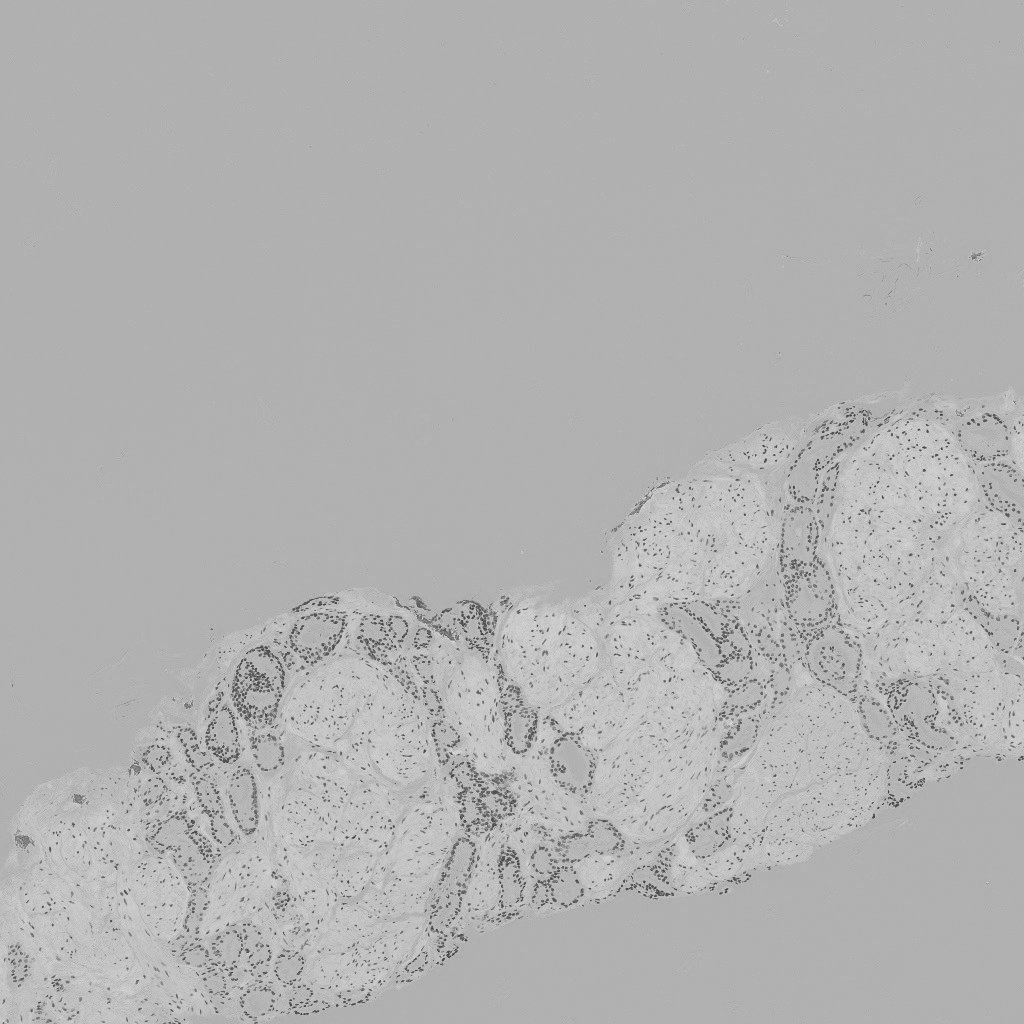


    Image #1:
    Origin: file:/content/tiles_output/file1/selected/file1_L2_T31.jpg
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


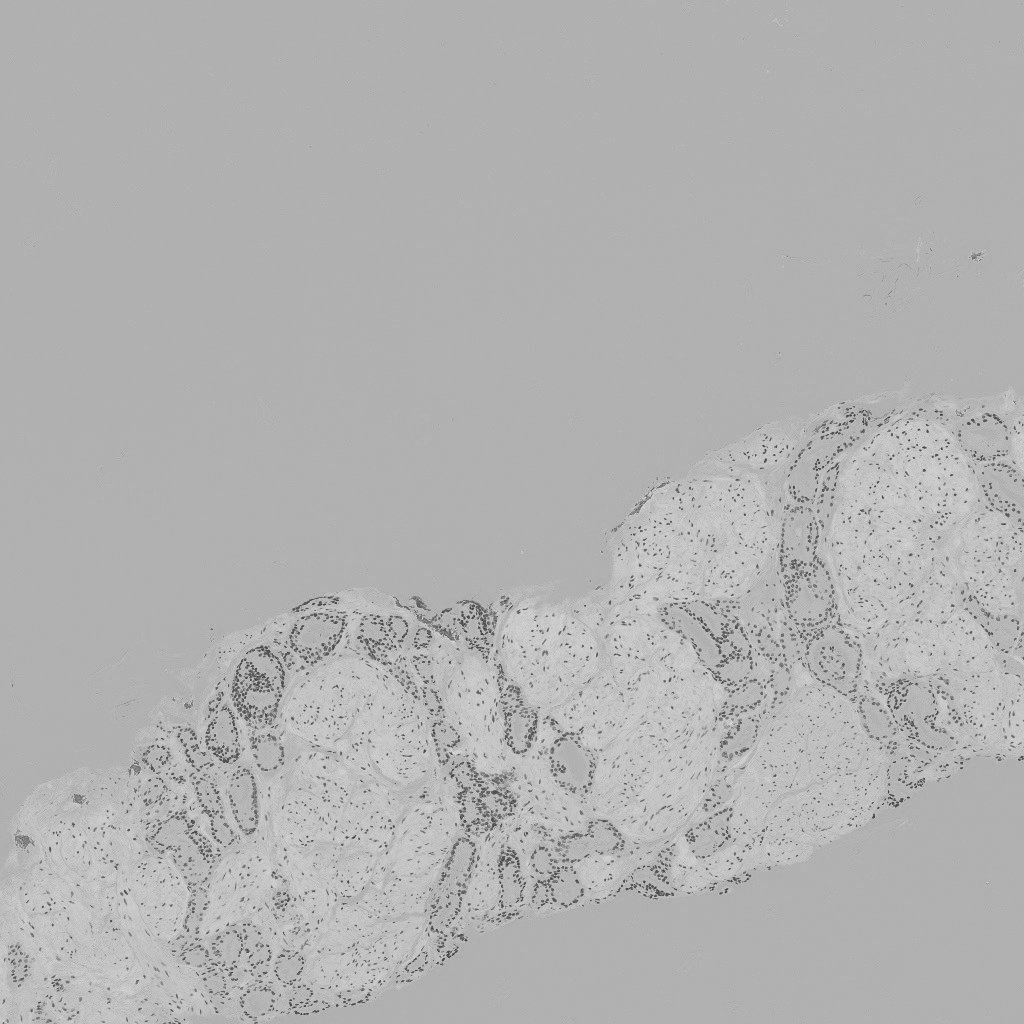


    Image #2:
    Origin: file:/content/tiles_output/file2/selected/file2_L2_T3.jpg
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


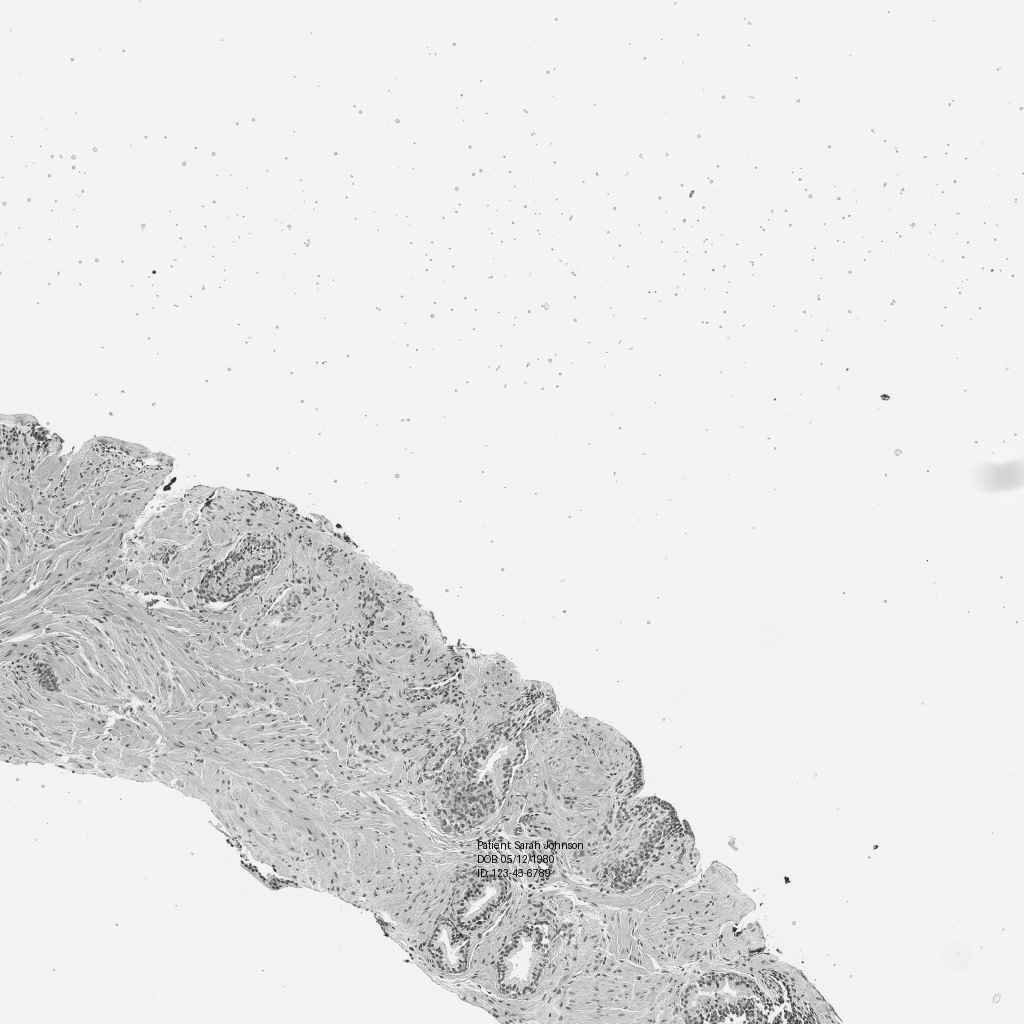


    Image #3:
    Origin: file:/content/tiles_output/file2/selected/file2_L2_T2.jpg
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


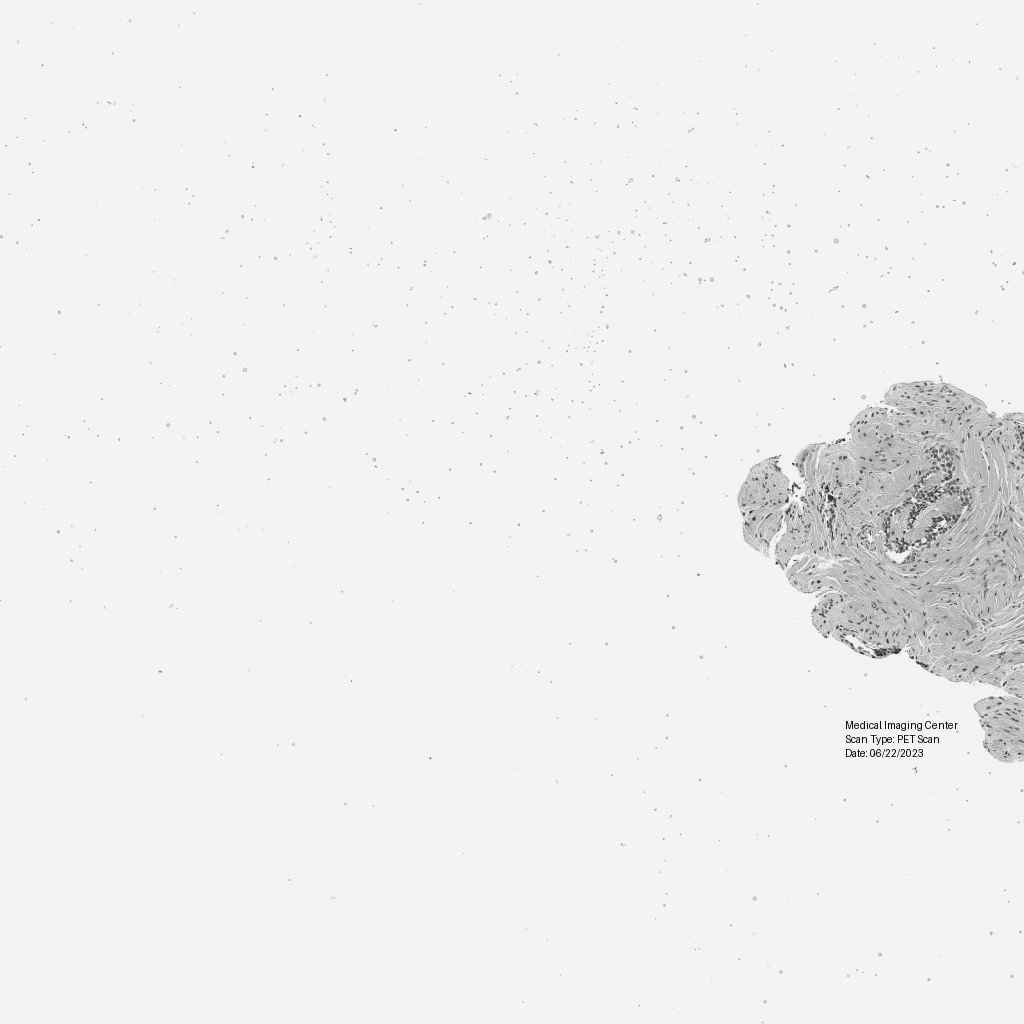


    Image #4:
    Origin: file:/content/tiles_output/file2/selected/file2_L2_T5.jpg
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


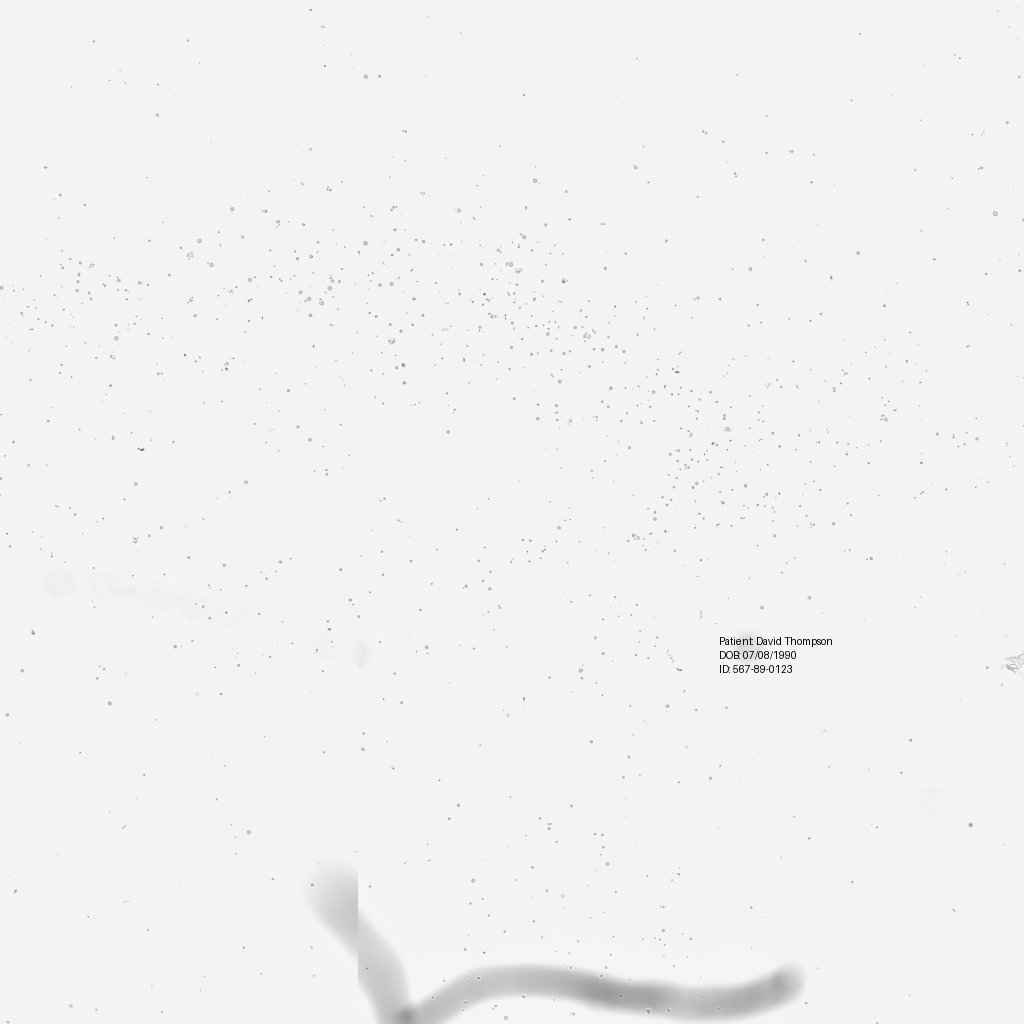

In [ ]:
from pyspark.sql.functions import size

result = result.filter(size(result["text_regions"]) > 0).cache()
display_images(result, "image_raw")

#### PHI removal per-se

In [ ]:
from sparkocr.pretrained import PretrainedPipeline
deid_pipeline = PretrainedPipeline("image_deid_multi_model_context_pipeline_cpu", "en", "clinical/ocr")

image_deid_multi_model_context_pipeline_cpu download started this may take some time.
Approx size to download 5.3 GB
[OK!]


### Run pipeline

In [ ]:
result_deid = deid_pipeline.transform(result)
deid_info = result_deid.select("path", "coordinates").distinct()

In [ ]:
deid_info.distinct().show(5, False)

#### [optional] Cache regions using parquet
We can cache the regions in disk, to avoid potential re-computation and to be able to recover in case of failure.

In [ ]:
deid_info.repartition(10).write.format("parquet").mode("overwrite").save("./cached_regions.parquet")

In [ ]:
deid_info = spark.read.parquet("./cached_regions.parquet").repartition(10)

#### Display deid tile
Let's take a look at the result of this process


    Image #0:
    Origin: file:/content/tiles_output/file4/selected/file4_L2_T31.jpg
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


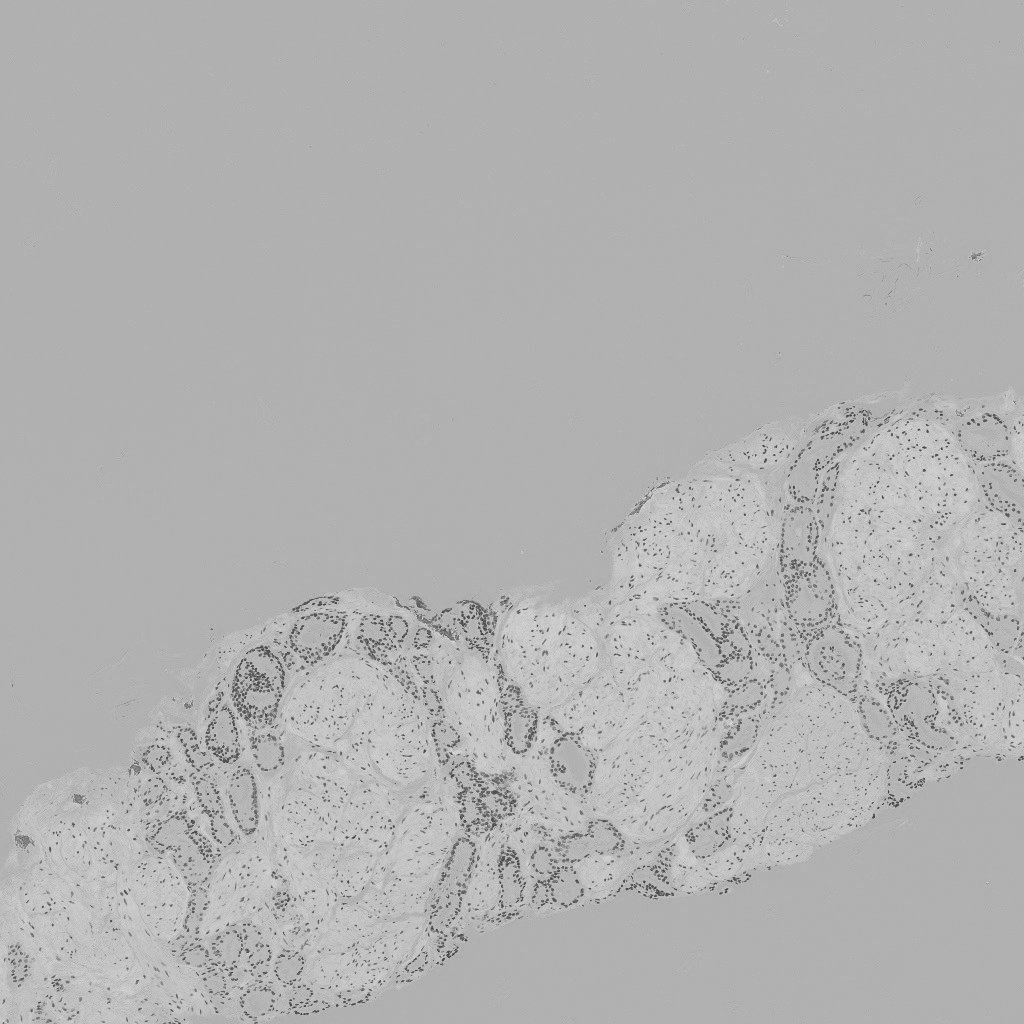


    Image #1:
    Origin: file:/content/tiles_output/file1/selected/file1_L2_T31.jpg
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


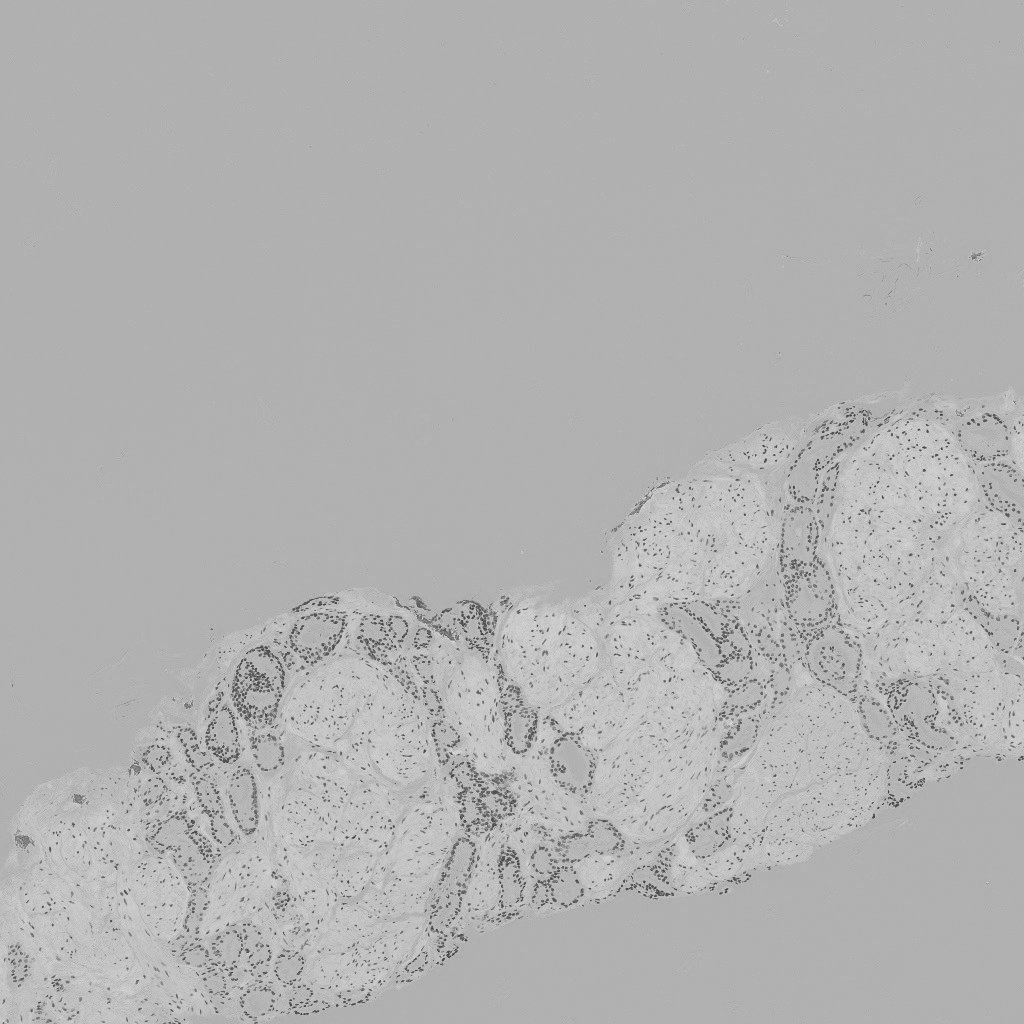


    Image #2:
    Origin: file:/content/tiles_output/file6/selected/file6_L2_T31.jpg
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


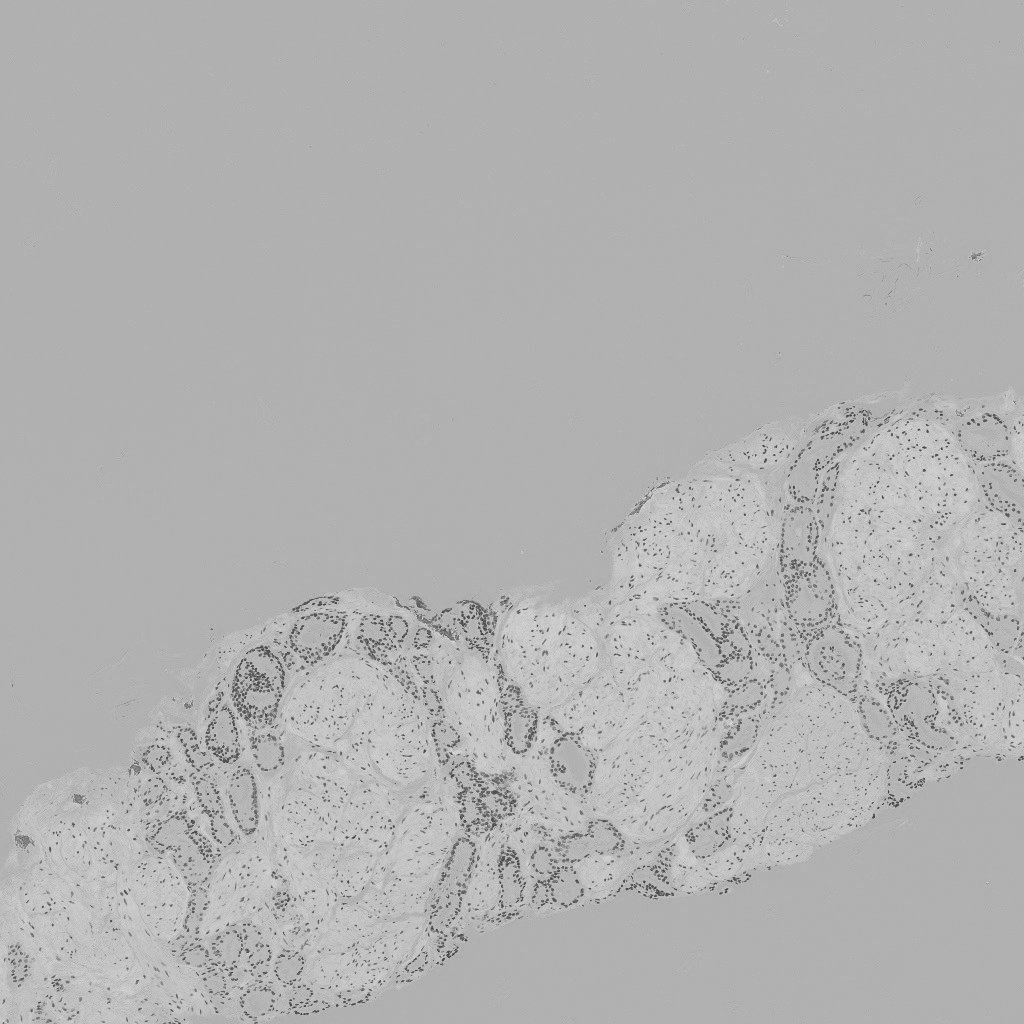


    Image #3:
    Origin: file:/content/tiles_output/file3/selected/file3_L2_T31.jpg
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


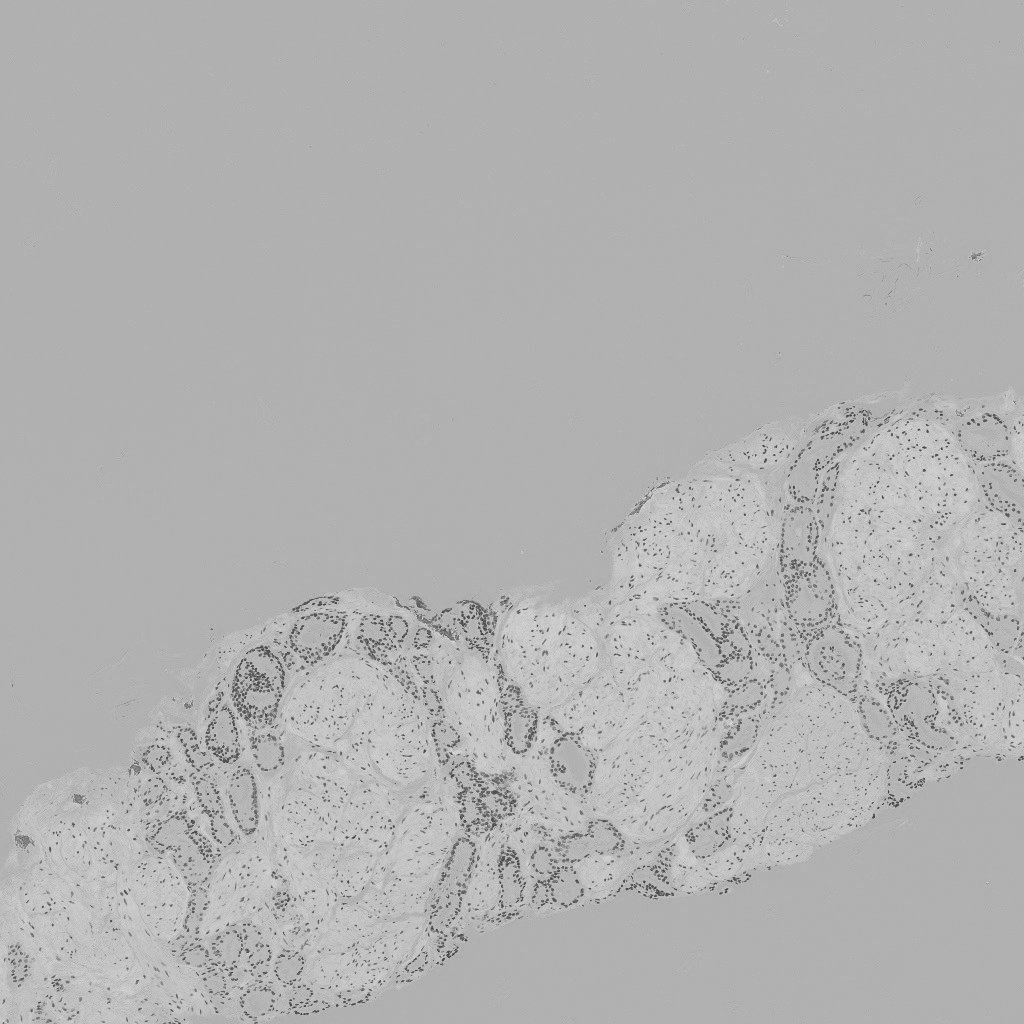


    Image #4:
    Origin: file:/content/tiles_output/file6/selected/file6_L2_T3.jpg
    Resolution: 0 dpi
    Width: 1024 px
    Height: 1024 px
    Mode: 10
    Number of channels: 1


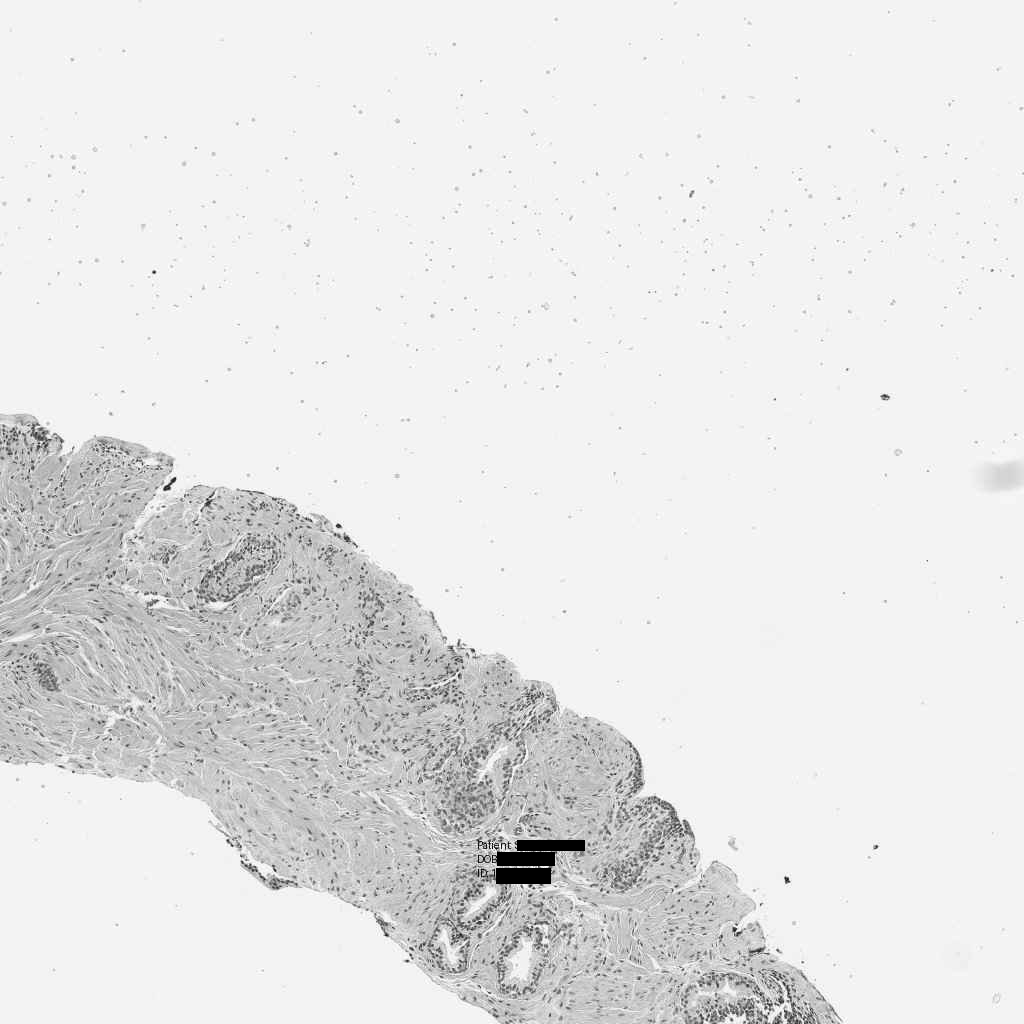

In [ ]:
from sparkocr.utils import display_images
display_images(result_deid, "image_with_regions")

#### Masking of specific tiles in the SVS
This is our final step!. We will mask the specific tiles —which will be scaled to the other levels in the image pyramid— in the source SVS using the regions we obtained during previous steps.</br>
First, let's create a copy of our files.

In [ ]:
!cp -r "$output_path" deid_svs_copy

In [ ]:
!mkdir /content/svs_deid
svs_path_out = "/content/svs_deid/"

In [ ]:
from sparkocr.utils.svs.phi_redaction import redact_phi_in_tiles
redact_phi_in_tiles("deid_svs_copy", deid_info, OUTPUT_FOLDER, output_svs_path=svs_path_out, create_new_svs_file = True)

Group 1/1: 100%|██████████| 2/2 [00:00<00:00, 13.13file/s]
